In [1]:
# Import libraries
%pylab inline
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load sample order and labels
sampleinfo = pd.read_csv("~/public/1000Genomes/igsr_samples.tsv", sep="\t")
sample_to_pop = dict(zip(list(sampleinfo["Sample name"]), list(sampleinfo["Population code"])))
samples = [line.split()[0] for line in open("ps2_admixture.pruned.fam", "r").readlines()]
pops = [sample_to_pop.get(item, "NA") for item in samples]
for item in pops:
    assert(item in ["CEU", "PEL", "GWD", "ASW", "PUR"])

Populating the interactive namespace from numpy and matplotlib
These are the actual results from the admixture tool 


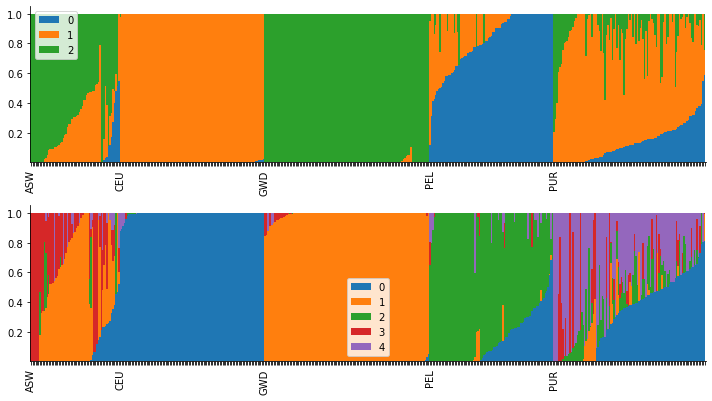

In [3]:
""" Check ADMIXTURE results """
%pylab inline

# The code below makes ADMIXTURE bar plots based on your results
# It will fail if your ADMIXTURE run was not complete or if you did not
# output results to the specified output files!
# Please ensure you get plots (and the notebook validates)
# to get full points.

sampleinfo = pd.read_csv("~/public/1000Genomes/igsr_samples.tsv", sep="\t")
sample_to_pop = dict(zip(list(sampleinfo["Sample name"]), list(sampleinfo["Population code"])))
samples = [line.split()[0] for line in open("ps2_admixture.pruned.fam", "r").readlines()]
pops = [sample_to_pop.get(item, "NA") for item in samples]

fig = plt.figure()
fig.set_size_inches((10, 8))

plotind = 1
for K in [3, 5]:
    ax = fig.add_subplot(3, 1, plotind)
    
    data = pd.read_csv("ps2_admixture.pruned.%s.Q"%K, delim_whitespace=True, header=None)
    cols = list(data.columns)
    data["sample"] = samples
    data["pop"] = pops
    data = data.sort_values(["pop"]+cols)
    data.plot.bar(stacked=True, ax=ax, width=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # Only plot label for first sample in each pop
    xticklabels = []
    currpop = ""
    for i in range(data.shape[0]):
        if data["pop"].values[i] == currpop:
            xticklabels.append("")
        else:
            xticklabels.append(data["pop"].values[i])
            currpop = data["pop"].values[i]
    ax.set_xticklabels(xticklabels)
    
    plotind += 1
fig.tight_layout()


print("These are the actual results from the admixture tool " )

In [4]:
import numpy as np
### this is the code for reading from the .bed file 
print("starting reading ")

def read_bed_file(bed_file_path, num_individuals, num_snps):
    """Read genotype data from a .bed file."""
    # Open the .bed file in binary mode
    with open(bed_file_path, 'rb') as bed_file:
        # Skip the header
        bed_file.read(3)
        
        # Calculate the number of bytes to read per row
        bytes_per_row = (num_individuals + 3) // 4
        
        # Initialize an empty array to store the genotype data
        genotypes = np.zeros((num_snps, num_individuals), dtype=float)
        
        for snp_index in range(num_snps):
            # Read a row of data
            row_data = bed_file.read(bytes_per_row)
            byte_array = np.frombuffer(row_data, dtype=np.uint8)
            
            # Decode the genotypes from the byte array
            for i in range(num_individuals):
                byte_index = i // 4
                if byte_index >= len(byte_array):
                    break
                
                # Extracting bits for one individual
                # Bits are stored in reverse order for each individual
                bit_index = (i % 4) * 2
                genotype_code = (byte_array[byte_index] >> bit_index) & 0b11
                
                # Convert the binary genotype code to the actual genotype
                if genotype_code == 0b00:
                    genotypes[snp_index, i] = 0  # Homozygous first allele
                elif genotype_code == 0b01:
                    genotypes[snp_index, i] = 1  # Heterozygous
                elif genotype_code == 0b11:
                    genotypes[snp_index, i] = 2  # Homozygous second allele
                elif genotype_code == 0b10:
                    genotypes[snp_index, i] = np.nan  # Missing genotype
                else:
                    raise ValueError(f'Unexpected genotype code: {genotype_code}')
                    
    return genotypes

# Parameters: Update these based on your .bed file
bed_file_path = "ps2_admixture.pruned.bed"
num_individuals = 462  # Update with the correct number of individuals in your dataset
num_snps = 26499  # Update with the correct number of SNPs

# Read the genotype data from the .bed file
genotype_matrix = read_bed_file(bed_file_path, num_individuals, num_snps)
print('Genotype matrix shape:', genotype_matrix.shape)

(unique, counts) = np.unique(genotype_matrix, return_counts=True)

frequencies = np.asarray((unique, counts)).T

# Change binary genotype to ped+map format
#plink --bfile ps2_admixture.pruned.bed --cow --nonfounders --allow-no-sex --recode --out ps2_admix_trial
dimensions = genotype_matrix.shape
print(dimensions, frequencies)

starting reading 
Genotype matrix shape: (26499, 462)
(26499, 462) [[0.0000000e+00 4.2215400e+05]
 [1.0000000e+00 1.9223000e+04]
 [2.0000000e+00 1.0037297e+07]
 [          nan 1.7638640e+06]]


In [9]:
import numpy as np
from tqdm import tqdm

#### run this code 
print('starting now ')
targ_Q = np.array(pd.read_csv("ps2_admixture.pruned.3.Q", delim_whitespace=True, header=None))
targ_P = np.array(pd.read_csv("ps2_admixture.pruned.3.P", delim_whitespace=True, header=None))
def naive_admixture(genotypes, num_individuals, num_snps, K=3, num_iterations=1000):
    # Initialize P (allele frequencies) randomly for each SNP for each population
    P = (np.random.rand(num_snps, K)/5)+0.4
    
    # Initialize Q (ancestry proportions) randomly for each individual
    Q = (np.random.rand(num_individuals, K)/5)+0.4
    
    # Normalize P and Q so they sum to 1 across the K populations
    P /= P.sum(axis=1, keepdims=True)
    Q /= Q.sum(axis=1, keepdims=True)
    N_limit = 90  # EM algorithm with progress bar from tqdm
    for iter in tqdm(range(num_iterations), desc="EM Iterations"):
        # E-step: Estimate ancestry fractions
        for i in range(num_individuals):
            stoch_indices = np.random.choice(num_snps, N_limit, replace = False)
            curr_genotypes = genotypes[stoch_indices,i]
            probs = P[stoch_indices,:] ** np.tile(curr_genotypes.reshape(-1,1), (1,K)) * (1-P[stoch_indices,:]) ** (2-np.tile(curr_genotypes.reshape(-1,1), (1,K)))
            good_indices = np.logical_not(np.any(np.isnan(probs), 1))
            probs = probs[good_indices]
            good_indices = np.logical_not(np.any(probs==0, 1))
            probs = probs[good_indices]
            probs = probs / probs.sum(1).reshape(-1,1)
            
            log_probs = np.sum(np.log(probs), 0)
            log_probs = log_probs - log_probs.max()
            Q[i] = np.exp(log_probs) + 1e-10
            Q[i] = Q[i] / Q[i].sum()
#             print(Q[i])
#             asdf
#             print(curr_genotypes)
#             print(curr_genotypes.shape)
#             print(P.shape)
#             asdf
            
            
            
#             for j in range(num_snps-1):
#                 genotype = genotypes[j, i]
#                 probs = P[j] ** genotype * (1 - P[j]) ** (2 - genotype)
#                 if np.any(np.isnan(probs)):
#                     continue
#                 Q[i] *= probs
                
            # Normalize Q for this individual
        
            

        # M-step: Update allele frequencies
#         for j in tqdm(range(num_snps), desc="M-step", leave=False):
        for j in range(num_snps):
            for k in range(K):
                curr_genotypes = genotypes[j]
                good_indices = np.logical_not(np.isnan(curr_genotypes))
                curr_Q = Q[:,k]
                curr_Q = curr_Q[good_indices]
                curr_genotypes = curr_genotypes[good_indices]
                P[j, k] = np.sum(curr_Q * curr_genotypes) / (1e-10 + (2 * np.sum(curr_Q)))
            # Normalize P for this SNP
            P[j] /= P[j].sum()
        
        if iter % 50 == 0:
            l1_P = np.abs((targ_P - P)).mean().round(4)
            l1_Q = np.abs((targ_Q - Q)).mean().round(4)
            print('P L1 loss = {}                  Q L1 Loss = {}'.format(l1_P, l1_Q))

    # Save results to files
    np.savetxt('result.Q', Q, fmt='%f')
    np.savetxt('result.P', P, fmt='%f')
    
    return Q, P

# Assuming 'genotype_matrix' is already defined and loaded with your actual genotype data
# Running the naive admixture analysis
### These L1 losses are not very accurate as the original population codes are getting changed. 
Q, P = naive_admixture(genotype_matrix, num_individuals, num_snps)
print('done')


starting now 


EM Iterations:   0%|          | 1/1000 [00:01<24:07,  1.45s/it]

P L1 loss = 0.5645                  Q L1 Loss = 0.4081


EM Iterations:   5%|▌         | 51/1000 [01:15<23:53,  1.51s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2453


EM Iterations:  10%|█         | 101/1000 [02:26<20:46,  1.39s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2516


EM Iterations:  15%|█▌        | 151/1000 [03:40<21:13,  1.50s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2495


EM Iterations:  20%|██        | 201/1000 [04:53<19:40,  1.48s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2495


EM Iterations:  25%|██▌       | 251/1000 [06:08<18:49,  1.51s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2403


EM Iterations:  30%|███       | 301/1000 [07:22<16:59,  1.46s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2501


EM Iterations:  35%|███▌      | 351/1000 [08:36<15:39,  1.45s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2505


EM Iterations:  40%|████      | 401/1000 [09:49<14:44,  1.48s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2427


EM Iterations:  45%|████▌     | 451/1000 [11:02<13:06,  1.43s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2413


EM Iterations:  50%|█████     | 501/1000 [12:16<12:07,  1.46s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.239


EM Iterations:  55%|█████▌    | 551/1000 [13:34<11:37,  1.55s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2465


EM Iterations:  60%|██████    | 601/1000 [14:53<10:30,  1.58s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2419


EM Iterations:  65%|██████▌   | 651/1000 [16:11<09:27,  1.63s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2424


EM Iterations:  70%|███████   | 701/1000 [17:32<08:27,  1.70s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2448


EM Iterations:  75%|███████▌  | 751/1000 [18:57<06:50,  1.65s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2437


EM Iterations:  80%|████████  | 801/1000 [20:21<05:46,  1.74s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2507


EM Iterations:  85%|████████▌ | 851/1000 [21:49<04:24,  1.78s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2433


EM Iterations:  90%|█████████ | 901/1000 [23:17<02:58,  1.80s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2483


EM Iterations:  95%|█████████▌| 951/1000 [24:48<01:28,  1.81s/it]

P L1 loss = 0.5624                  Q L1 Loss = 0.2419


EM Iterations: 100%|██████████| 1000/1000 [26:16<00:00,  1.58s/it]

done


Populating the interactive namespace from numpy and matplotlib
These are the actual results from the admixture tool 


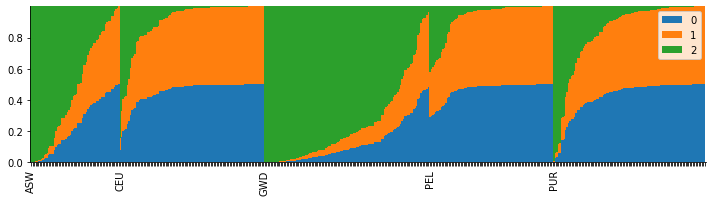

In [10]:
%pylab inline

# The code below makes ADMIXTURE bar plots based on your results
# It will fail if your ADMIXTURE run was not complete or if you did not
# output results to the specified output files!
# Please ensure you get plots (and the notebook validates)
# to get full points.

sampleinfo = pd.read_csv("~/public/1000Genomes/igsr_samples.tsv", sep="\t")
sample_to_pop = dict(zip(list(sampleinfo["Sample name"]), list(sampleinfo["Population code"])))
samples = [line.split()[0] for line in open("ps2_admixture.pruned.fam", "r").readlines()]
pops = [sample_to_pop.get(item, "NA") for item in samples]

fig = plt.figure()
fig.set_size_inches((10, 8))

plotind = 1
for K in [3]:
    ax = fig.add_subplot(3, 1, plotind)
    
    data = pd.read_csv("result.Q", delim_whitespace=True, header=None)
    cols = list(data.columns)
    data["sample"] = samples
    data["pop"] = pops
    data = data.sort_values(["pop"]+cols)
    data.plot.bar(stacked=True, ax=ax, width=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # Only plot label for first sample in each pop
    xticklabels = []
    currpop = ""
    for i in range(data.shape[0]):
        if data["pop"].values[i] == currpop:
            xticklabels.append("")
        else:
            xticklabels.append(data["pop"].values[i])
            currpop = data["pop"].values[i]
    ax.set_xticklabels(xticklabels)
    
    plotind += 1
fig.tight_layout()


print("These are the actual results from the admixture tool " )

In [ ]:
##### #All the cells after this are just other codes that didn't work, you can take a look if you want but there
##### are not considered a part of the projetct currently. 

In [ ]:
import numpy as np
#######dont run this , this is too slow. 
def naive_admixture(genotypes, num_individuals, num_snps, K=3, num_iterations=10):
    # Initialize P (allele frequencies) randomly for each SNP for each population
    P = np.random.rand(num_snps, K)
    
    # Initialize Q (ancestry proportions) randomly for each individual
    Q = np.random.rand(num_individuals, K)
    
    # Normalize P and Q so they sum to 1 across the K populations
    P /= P.sum(axis=1, keepdims=True)
    Q /= Q.sum(axis=1, keepdims=True)
    
    # EM algorithm
    for _ in range(num_iterations):
        # E-step: Estimate ancestry fractions
        # Here we assume genotypes are encoded as 0, 1, or 2
        # and use a very simple model where each genotype
        # probability is just the product of allele frequencies
        for i in range(num_individuals):
            for j in range(num_snps):
                genotype = genotypes[j, i]
                probs = P[j] ** genotype * (1 - P[j]) ** (2 - genotype)
                if np.any(np.isnan(probs)):
                    continue
                Q[i] *= probs
                
            # Normalize Q for this individual
            Q[i] /= Q[i].sum()

        # M-step: Update allele frequencies
        for j in range(num_snps):
            for k in range(K):
                # This is a very naive way to update allele frequencies,
                # just based on the average ancestry fraction weighted by genotype
                P[j, k] = np.sum(Q[:, k] * genotypes[j]) / (2 * np.sum(Q[:, k]))
                
            # Normalize P for this SNP
            P[j] /= P[j].sum()

    # Save results to files
    np.savetxt('result.Q', Q, fmt='%f')
    np.savetxt('result.P', P, fmt='%f')
    
    return Q, P

# Dummy data for testing the function
num_individuals = 668  # Replace with your actual number of individuals
num_snps = 205857      # Replace with your actual number of SNPs

# Randomly generated dummy genotype data
# In real scenario, you would read from your .bed file
##genotypes = np.random.randint(0, 3, (num_snps, num_individuals))
genotypes = genotype_matrix
# Running the naive admixture analysis
Q, P = naive_admixture(genotypes, num_individuals, num_snps)
print('done')

In [4]:
## This is our code for the admixture 

################ code 2 for the admixtute, runs on the input bed file 

import numpy as np
print('starting code ')
def read_bed_file(bed_file_path, num_individuals, num_snps):
    """Read genotype data from a .bed file."""
    # Open the .bed file in binary mode
    with open(bed_file_path, 'rb') as bed_file:
        # Skip the header
        bed_file.read(3)
        
        # Calculate the number of bytes to read per row
        bytes_per_row = (num_individuals + 3) // 4
        
        # Initialize an empty array to store the genotype data
        genotypes = np.zeros((num_snps, num_individuals), dtype=float)
        
        for snp_index in range(num_snps):
            # Read a row of data
            row_data = bed_file.read(bytes_per_row)
            byte_array = np.frombuffer(row_data, dtype=np.uint8)
            
            # Decode the genotypes from the byte array
            for i in range(num_individuals):
                byte_index = i // 4
                if byte_index >= len(byte_array):
                    #print('breaking oh no ')
                    break
                bit_index = (i % 4) * 2
                genotype_code = (byte_array[byte_index] >> bit_index) & 0b11
                #print(genotype_code)
                if genotype_code == 0b00:
                    genotypes[snp_index, i] = 0  # Homozygous first allele
                elif genotype_code == 0b11:
                    #print('hit')
                    genotypes[snp_index, i] = 2  # Homozygous second allele
                elif genotype_code == 0b01  :
                    genotypes[snp_index, i] = 1  # Heterozygous
                else:
                    #print( genotype_code)
                    genotypes[snp_index, i] = np.nan  # Missing genotype
                    
    return genotypes

# Parameters: Update these based on your .bed file
bed_file_path = "ps2_admixture.pruned.bed"
num_individuals =462   
#668  # Update with the correct number of individuals in your dataset
num_snps = 26499   
##205857       # Update with the correct number of SNPs
bytes_per_row = (num_individuals * 2 + 7) // 8

# Read the genotype data from the .bed file
genotype_matrix = read_bed_file(bed_file_path, num_individuals, num_snps)
print(genotype_matrix.shape)
# You can now proceed with your admixture analysis using the `genotype_matrix`

import numpy as np

def estimate_allele_frequencies(genotype_matrix):
    """Estimate allele frequencies in the genotype data."""
    # Count alleles (note: assumes 0, 1, 2 coding for genotypes)
    allele_counts = np.nansum(genotype_matrix, axis=1)
    # Count non-missing genotypes
    non_missing_counts = np.count_nonzero(~np.isnan(genotype_matrix), axis=1) * 2
    # Calculate frequencies
    allele_frequencies = allele_counts / non_missing_counts
    return allele_frequencies

def estimate_admixture_proportions(genotype_matrix, ancestral_freqs):
    """Estimate admixture proportions based on allele frequencies."""
    num_individuals = genotype_matrix.shape[1]
    admixture_proportions = np.zeros((num_individuals, len(ancestral_freqs)))
    
    for i, individual_genotypes in enumerate(genotype_matrix.T):  # Iterate through individuals
        for j, freqs in enumerate(ancestral_freqs):  # Iterate through ancestral populations
            # Calculate similarity score based on allele frequencies
            similarity_score = np.nansum(np.abs(individual_genotypes - freqs))
            admixture_proportions[i, j] = similarity_score
    
    # Normalize admixture proportions so they sum to 1 for each individual
    admixture_proportions = 1 - (admixture_proportions / np.nansum(admixture_proportions, axis=1, keepdims=True))
    
    return admixture_proportions

# Load your genotype_matrix from the .bed file as shown in the previous example

# Hypothetical allele frequencies for two ancestral populations
ancestral_freqs = [
    np.random.uniform(0, 1, genotype_matrix.shape[0]),  # Ancestral pop 1
    np.random.uniform(0, 1, genotype_matrix.shape[0])   # Ancestral pop 2
]

# Estimate admixture proportions
admixture_proportions = estimate_admixture_proportions(genotype_matrix, ancestral_freqs)

# Example: Print admixture proportions for the first 5 individuals
print(admixture_proportions[:5])



## IF we want to run it without any asssumptions about allelle frequencies.  

import numpy as np
from sklearn.cluster import KMeans

def estimate_allele_frequencies(genotype_matrix):
    """Estimate allele frequencies in the genotype data."""
    # Assuming 0, 1, 2 encoding for genotypes
    allele_counts = np.nansum(genotype_matrix, axis=1)
    # Count non-missing genotypes
    non_missing_counts = np.count_nonzero(~np.isnan(genotype_matrix), axis=1) * 2
    # Calculate frequencies
    allele_frequencies = allele_counts / non_missing_counts
    return allele_frequencies

def cluster_individuals(genotype_matrix, n_clusters=2):
    """Cluster individuals based on their genetic data."""
    # Transpose matrix to have individuals as rows
    individuals_matrix = genotype_matrix.T
    # Handle missing data by imputing with the mean
    nan_mask = np.isnan(individuals_matrix)
    mean_genotypes = np.nanmean(individuals_matrix, axis=0)
    individuals_matrix[nan_mask] = np.take(mean_genotypes, np.where(nan_mask)[1])
    # Use KMeans for clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(individuals_matrix)
    return kmeans.labels_, kmeans.cluster_centers_

def estimate_admixture_proportions(cluster_centers):
    """Estimate admixture proportions based on cluster centers."""
    # Normalize cluster centers to get admixture proportions
    admixture_proportions = cluster_centers / np.sum(cluster_centers, axis=1, keepdims=True)
    return admixture_proportions

# Load your genotype_matrix from the .bed file as shown in the previous example

# Cluster individuals (adjust n_clusters as needed)
#labels, cluster_centers = cluster_individuals(genotype_matrix, n_clusters=2)

# Estimate admixture proportions based on the cluster centers
#admixture_proportions = estimate_admixture_proportions(cluster_centers)

# Example: Print the cluster assignment for the first 5 individuals
#print("Cluster labels for the first 5 individuals:", labels[:5])
print('done')
dimensions = genotype_matrix.shape



# Calculate frequencies of all values

(unique, counts) = np.unique(genotype_matrix, return_counts=True)

frequencies = np.asarray((unique, counts)).T

# Change binary genotype to ped+map format
#plink --bfile ps2_admixture.pruned.bed --cow --nonfounders --allow-no-sex --recode --out ps2_admix_trial

print(dimensions, frequencies)

starting code 


KeyboardInterrupt: 

In [40]:
def initialize_P_from_bim(bim_file_path, num_snps, K):
    allele_frequencies = np.zeros((num_snps, 2))  # Assuming two alleles per SNP
    with open(bim_file_path, 'r') as bim_file:
        for snp_index, line in enumerate(bim_file):
            parts = line.strip().split()
            # parts[4] is the minor allele frequency (MAF) for this SNP, if available
            # Otherwise, you would have to calculate it from your genotype data
            # Here, we're just using a placeholder value
            maf = float(parts[4])  
            allele_frequencies[snp_index] = [maf, 1 - maf]  # Assuming the first allele is the minor allele
    
    # Randomly initialize P based on allele frequencies
    # This is a simplistic way to use the allele frequencies for initialization
    P = np.zeros((num_snps, K))
    for k in range(K):
        P[:, k] = allele_frequencies[:, 0] + (np.random.rand(num_snps) * (allele_frequencies[:, 1] - allele_frequencies[:, 0]))
    
    P /= P.sum(axis=1, keepdims=True)
    return P

def initialize_Q_from_fam(fam_file_path, num_individuals, K):
    Q = np.zeros((num_individuals, K))
    with open(fam_file_path, 'r') as fam_file:
        for i, line in enumerate(fam_file):
            parts = line.strip().split()
            population_label = parts[5]  # Assuming population label is in the sixth column
            # Convert population_label to an index and assign the initial ancestry proportion
            # Here, you'd have a mapping of population labels to indices
            Q[i, population_label_to_index[population_label]] = 1
    
    Q /= Q.sum(axis=1, keepdims=True)
    return Q

P_init = initialize_P_from_bim('ps2_admixture.pruned.bim', num_snps, 3)
Q_init = initialize_Q_from_fam('ps2_admixture.pruned.fam', num_individuals, 3)

ValueError: could not convert string to float: 'C'

In [26]:
import numpy as np
import pandas as pd

# Load your genotype matrix where rows are SNPs and columns are individuals
# For demonstration, let's assume it's already loaded into a variable named `genotype_matrix`

# Let's assume the genotype_matrix is coded as:
# 0 for the homozygous reference allele
# 1 for the heterozygous allele
# 2 for the homozygous alternate allele
# NaN for missing data

# Calculate the frequency of the alternate allele (allele 2 from the .bim file)
allele_2_counts = np.nansum(genotype_matrix, axis=1)  # Sum the genotypes for each SNP
heterozygous_counts = np.sum(genotype_matrix == 1, axis=1)  # Count the heterozygotes
allele_2_frequencies = (allele_2_counts + heterozygous_counts) / (2 * (~np.isnan(genotype_matrix)).sum(axis=1))

# If you need frequencies of the reference allele, simply subtract from 1
allele_1_frequencies = 1 - allele_2_frequencies
import numpy as np

# Assume genotype_matrix is loaded, with shape (num_snps, num_individuals)
# and contains genotypes encoded as 0, 1, 2, and NaN for missing data.

# Calculate allele 2 frequencies
allele_2_counts = np.nansum(genotype_matrix, axis=1)  # Sum the genotypes for each SNP
heterozygous_counts = np.sum(genotype_matrix == 1, axis=1)  # Count the heterozygotes
allele_2_frequencies = (allele_2_counts + heterozygous_counts) / (2 * (~np.isnan(genotype_matrix)).sum(axis=1))

# Initialize P using these frequencies
num_snps, num_individuals = genotype_matrix.shape
K = 3  # For example, assuming there are 3 populations
P = np.zeros((num_snps, K))

for k in range(K):
    # Use the allele 2 frequencies to initialize one allele's frequency in P
    # and assume that allele 1's frequency is (1 - allele 2 frequency)
    # You can add some noise to these initial frequencies if desired
    P[:, k] = allele_2_frequencies + np.random.normal(0, 0.1, num_snps)  # Adding small noise

# Ensure P's frequencies are normalized
P = np.clip(P, 0.0001, 0.9999)  # Clip values to avoid 0 or 1, which are problematic in log calculations
P /= P.sum(axis=1, keepdims=True)


In [27]:
allele_2_frequencies.shape
P[0:100]


array([[0.33496071, 0.33007857, 0.33496071],
       [0.36782972, 0.34122868, 0.2909416 ],
       [0.32455483, 0.33772259, 0.33772259],
       [0.35596366, 0.34645851, 0.29757783],
       [0.35160963, 0.31503154, 0.33335884],
       [0.32718228, 0.3298621 , 0.34295562],
       [0.33333333, 0.33333333, 0.33333333],
       [0.34227167, 0.31545666, 0.34227167],
       [0.31993438, 0.35651119, 0.32355442],
       [0.37649258, 0.29033802, 0.3331694 ],
       [0.35269232, 0.31124179, 0.33606588],
       [0.32994447, 0.34000176, 0.33005377],
       [0.34934535, 0.29839873, 0.35225592],
       [0.34657085, 0.32702492, 0.32640424],
       [0.34026979, 0.37989269, 0.27983753],
       [0.34266054, 0.34816223, 0.30917723],
       [0.33283235, 0.24873967, 0.41842797],
       [0.35544937, 0.33131109, 0.31323954],
       [0.30764486, 0.31823334, 0.37412179],
       [0.31457598, 0.34271201, 0.34271201],
       [0.30355408, 0.34822296, 0.34822296],
       [0.29473722, 0.35006612, 0.35519666],
       [0.

In [8]:
genotype_matrix[:10]
genotype_matrix.shape


(26499, 462)

In [ ]:
import numpy as np
from scipy.optimize import minimize
from tqdm import tqdm
import pandas as pd
print("Starting the complex algo with Quasi Newton involved ")
# Assuming `genotype_matrix`, `num_individuals`, and `num_snps` are defined
# targ_Q and targ_P represent the target matrices for comparison

# Define the negative log-likelihood function
def neg_log_likelihood(params, genotypes, num_individuals, num_snps, K):
    P = params[:num_snps * K].reshape((num_snps, K))
    Q = params[num_snps * K:].reshape((num_individuals, K))
    nll = 0.0
    for i in range(num_individuals):
        for j in range(num_snps):
            genotype = genotypes[j, i]
            if not np.isnan(genotype):
                # Calculate the probability of the genotype given P and Q
                prob_geno = 0.0
                for k in range(K):
                    # Assuming Hardy-Weinberg Equilibrium for the allele frequencies
                    if genotype == 2.0:  # Homozygous for allele 2
                        prob_geno += Q[i, k] * (P[j, k] ** 2)
                    elif genotype == 1.0:  # Heterozygous
                        prob_geno += 2 * Q[i, k] * P[j, k] * (1 - P[j, k])
                    elif genotype == 0.0:  # Homozygous for allele 1
                        prob_geno += Q[i, k] * ((1 - P[j, k]) ** 2)
                nll -= np.log(prob_geno + 1e-10)  # Add a small value to avoid log(0)
    return nll


def gradient(params, genotypes, num_individuals, num_snps, K):
    P = params[:num_snps * K].reshape((num_snps, K))
    Q = params[num_snps * K:].reshape((num_individuals, K))
    
    # Placeholder for the actual gradient computation
    # The gradients should be the same shape as the parameter array
    grad_P = np.zeros_like(P)
    grad_Q = np.zeros_like(Q)
    
    # Compute the gradient here...
    # This requires calculating the partial derivatives of the negative log-likelihood
    # with respect to each element of P and Q
    calculate_gradient_P(Q, genotypes, P, num_individuals, num_snps)
    calculate_gradient_Q(P, genotypes, Q, num_individuals, num_snps)
    
    # Flatten and concatenate gradients to match the shape of 'params'
    return np.concatenate([grad_P.flatten(), grad_Q.flatten()])
def calculate_gradient_P(Q, genotypes, P, individual, snp):
    """
    Calculate the gradient of the log-likelihood with respect to allele frequencies P.
    """
    grad_P = 0.0
    genotype = genotypes[snp-1, individual-1]
    
    if not np.isnan(genotype):
        # Probability of the genotype under Hardy-Weinberg Equilibrium
        prob_geno = (P[snp-1] ** 2) * (genotype == 2) + \
                    (2 * P[snp-1] * (1 - P[snp-1])) * (genotype == 1) + \
                    ((1 - P[snp-1]) ** 2) * (genotype == 0)
        
        # Derivative with respect to P
        if genotype == 2:
            grad_P = 2 * Q[individual-1] * P[snp-1] / prob_geno
        elif genotype == 1:
            grad_P = Q[individual-1] * (1 - 2 * P[snp-1]) / prob_geno
        elif genotype == 0:
            grad_P = -2 * Q[individual-1] * (1 - P[snp-1]) / prob_geno
    
    return grad_P

def calculate_gradient_Q(P, genotypes, Q, individual, snp):
    """
    Calculate the gradient of the log-likelihood with respect to ancestry proportions Q.
    """
    grad_Q = 0.0
    genotype = genotypes[snp-1, individual-1]
    
    if not np.isnan(genotype):
        # Probability of the genotype under Hardy-Weinberg Equilibrium
        prob_geno = (P[snp-1] ** 2) * (genotype == 2) + \
                    (2 * P[snp-1] * (1 - P[snp-1])) * (genotype == 1) + \
                    ((1 - P[snp-1]) ** 2) * (genotype == 0)
        
        # Derivative with respect to Q
        grad_Q = np.log(prob_geno) * (genotype == 2) + \
                 np.log(1 - prob_geno) * (genotype == 0)
    
    return grad_Q


def naive_admixture_with_quasi_newton(genotypes, num_individuals, num_snps, K, num_iterations=2500):
    # Flatten the initial P and Q matrices for use with BFGS
    initial_P = (np.random.rand(num_snps, K) / 5) + 0.4
    initial_P /= initial_P.sum(axis=1, keepdims=True)
    initial_Q = (np.random.rand(num_individuals, K) / 5) + 0.4
    initial_Q /= initial_Q.sum(axis=1, keepdims=True)
    initial_params = np.hstack((initial_P.flatten(), initial_Q.flatten()))
    
    # Run the BFGS optimization
    result = minimize(fun=neg_log_likelihood,
                      x0=initial_params,
                      args=(genotypes, num_individuals, num_snps, K),
                      jac=gradient,  # If you provide the gradient
                      method='BFGS',
                      options={'disp': True, 'maxiter': num_iterations})
    
    # Extract the optimized P and Q matrices
    optimized_params = result.x
    P = optimized_params[:num_snps * K].reshape((num_snps, K))
    Q = optimized_params[num_snps * K:].reshape((num_individuals, K))
    
    if iter % 2 == 0:
            l1_P = np.abs((targ_P - P)).mean().round(3)
            l1_Q = np.abs((targ_Q - Q)).mean().round(3)
            print('P L1 loss = {}\nQ L1 Loss = {}'.format(l1_P, l1_Q))
    
    return P, Q

# Run the admixture analysis with quasi-Newton acceleration
P, Q = naive_admixture_with_quasi_newton(genotype_matrix, num_individuals, num_snps, K=3, num_iterations=2500)
print('Optimization done')


Starting the complex algo with Quasi Newton involved 


In [78]:
import pandas as pd
import numpy as np

# Load the .raw file generated by PLINK
raw_data = pd.read_csv('orig.raw', delim_whitespace=True)

# Drop non-genotype columns. Assuming the first six columns are non-genotype data
genotype_data = raw_data.drop(raw_data.columns[:6], axis=1)

# Transpose the dataframe so that SNPs are rows and individuals are columns
genotype_matrix = genotype_data.transpose()

# Replace 0 with NaN to indicate missing data
genotype_matrix.replace(0, np.nan, inplace=True)

# Save to a .csv file
genotype_matrix.to_csv('genotype_matrix.csv', header=False, index=False)


In [80]:
genotype_matrix[0:10]

,0,1,2,3,4,5,6,7,8,9,...,452,453,454,455,456,457,458,459,460,461
rs539713234_C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rs78200054_T,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
rs559733149_T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
rs564500555_G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rs71235073_T,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rs368646645_C,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN
rs71235074_G,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rs71235075_T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rs533016209_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
rs373407518_T,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,...,1.0,NaN,1.0,2.0,1.0,1.0,1.0,1.0,NaN,1.0


In [ ]:
##plink --bfile ps2_admixture --recode A-transpose --out orig
##plink --bfile ps2_admixture --recode A --transpose --out orig